In [21]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time



In [2]:
import telegram
from keras.callbacks import Callback
from callbacks import TelegramCallback
from callbacks.TelegramData import TelegramData


# create callback
config = {
    'token': TelegramData.Token,   # paste your bot token
    'telegram_id': TelegramData.ID,                                   # paste your telegram_id
}

tg_callback = TelegramCallback(config)

In [3]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [4]:
train_ids = [1,2,3, 7, 8, 9, 10]
test_ids = [4,5,6]

In [6]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_blobs.pkl")
#df_train = dfAll[(dfAll.userID != 1) | (dfAll.userID != 2)]
#df_test = dfAll[(dfAll.userID == 1) | (dfAll.userID == 2)]
df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids)]

df_test = df_test.reset_index()
df_train = df_train.reset_index()
#Create InputMethod Column and fill it with Knuckel / Finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df_train['InputMethod'] = df_train.apply(f, axis=1)
df_test['InputMethod'] = df_test.apply(f, axis=1)
df_train2 = df_train[['Blobs', 'InputMethod']].copy()
df_test2 = df_test[['Blobs', 'InputMethod']].copy()

In [7]:
x_train = np.vstack(df_train2.Blobs)
x_test = np.vstack(df_test2.Blobs)
y_train = df_train2.InputMethod.values
y_test = df_test2.InputMethod.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [8]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = utils.to_categorical(df_train2.InputMethod, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.InputMethod, num_classes)

Text(0.5,1,'Label for image 1 is: 0')

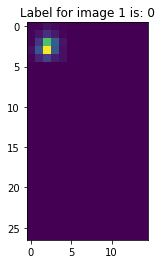

In [9]:
i = 1
plt.imshow(x_train[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y_train[i]))

In [10]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [16]:
MaxPooling2D?

In [ ]:
tf.get_default_graph()
########## HYPER PARAMETERS
batch_size = 200
epochs = 500
optimizer = optimizers.Adam(lr=0.001)
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
#init=tf.global_variables_initializer()

########## HYPER PARAMETERS
########## MODEL ARCHITECTURE
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(Dropout(0.50))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.02, 0.15), use_bias=True))
#model.add(Dropout(0.50))
model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.02, 0.15), use_bias=True))
#model.add(Dropout(0.50))
model.add(Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE
####TENSORBOARD
config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
#### END TENSORBOARD
config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n"

# Print summary
model.summary()
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_Jan_" + readable_timestamp
print("KnuckleFinger_Jan_" + readable_timestamp)
logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0,
                            write_graph=True, write_images=True, update_freq = 'epoch')
storer = ModelCheckpoint("./ModelSnapshots/KnuckleFinger_Jan_" + readable_timestamp + ".h5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=False, mode='auto', period=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.9, 
                                            min_lr=0.00001)
# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[logger, storer, tg_callback, learning_rate_reduction])
                    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 27, 15, 64)        640       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 27, 15, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 27, 15, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 8, 64)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 8, 64)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 8, 32)         18464     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 8, 32)         9248      
__________

47696/47696 [==============================] - 15s 307us/step - loss: 0.7212 - acc: 0.9508 - val_loss: 0.7900 - val_acc: 0.9284
Epoch 43/500
47696/47696 [==============================] - 15s 307us/step - loss: 0.7169 - acc: 0.9515 - val_loss: 0.7631 - val_acc: 0.9395
Epoch 44/500
47696/47696 [==============================] - 15s 308us/step - loss: 0.7163 - acc: 0.9523 - val_loss: 0.7773 - val_acc: 0.9367
Epoch 45/500
47696/47696 [==============================] - 15s 308us/step - loss: 0.7158 - acc: 0.9519 - val_loss: 0.7833 - val_acc: 0.9309
Epoch 46/500
47696/47696 [==============================] - 15s 307us/step - loss: 0.7149 - acc: 0.9532 - val_loss: 0.7932 - val_acc: 0.9291
Epoch 47/500
47696/47696 [==============================] - 15s 308us/step - loss: 0.7135 - acc: 0.9544 - val_loss: 0.7647 - val_acc: 0.9369
Epoch 48/500
47696/47696 [==============================] - 15s 308us/step - loss: 0.7137 - acc: 0.9537 - val_loss: 0.7555 - val_acc: 0.9364
Epoch 49/500
47696/47696 [

Epoch 98/500
47696/47696 [==============================] - 15s 308us/step - loss: 0.4779 - acc: 0.9692 - val_loss: 0.5864 - val_acc: 0.9378
Epoch 99/500
47696/47696 [==============================] - 15s 307us/step - loss: 0.4781 - acc: 0.9690 - val_loss: 0.6032 - val_acc: 0.9320
Epoch 100/500
47696/47696 [==============================] - 15s 308us/step - loss: 0.4792 - acc: 0.9682 - val_loss: 0.6194 - val_acc: 0.9313
Epoch 101/500
47696/47696 [==============================] - 15s 307us/step - loss: 0.4769 - acc: 0.9696 - val_loss: 0.5870 - val_acc: 0.9381

Epoch 00101: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
Epoch 102/500
47696/47696 [==============================] - 15s 307us/step - loss: 0.4396 - acc: 0.9692 - val_loss: 0.5407 - val_acc: 0.9394
Epoch 103/500
47696/47696 [==============================] - 15s 307us/step - loss: 0.4375 - acc: 0.9696 - val_loss: 0.5910 - val_acc: 0.9277
Epoch 104/500
47696/47696 [==============================] - 15s 308u

In [19]:
optimizers.Adam

SyntaxError: invalid syntax (<ipython-input-19-4d1ad3a896cd>, line 1)

In [ ]:
def cnn_model():
    optimizer = optimizers.Adam()
    #optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
    #init=tf.global_variables_initializer()

    model = Sequential()

    model.add(Conv2D(120, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1)))
    model.add(Conv2D(120, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
    model.add(Dropout(0.15))
    model.add(Conv2D(50, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(50, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
    model.add(Dropout(0.10))
    model.add(Flatten())
    model.add(Dense(400, activation=('relu'), use_bias=True))
    model.add(Dense(100, activation=('relu'), use_bias=True))
    model.add(Dense(num_classes, activation='softmax'))
    
    ####TENSORBOARD
    config = ""
    for layer in model.layers:
        config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
    config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n"
    #### END TENSORBOARD
     
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [ ]:
tf.get_default_graph()

readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_Jan_" + readable_timestamp

#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)
logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0, write_graph=True, write_images=True, update_freq = 'epoch')
model_checkpoint = ModelCheckpoint("./ModelSnapshots/KnuckleFinger_Jan_" + readable_timestamp + ".h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)


def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=500, BATCH_SIZE=200):
    model = None
    model = cnn_model()
    model.summary()
    history = model.fit(x_train, y_train_one_hot,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[logger, model_checkpoint, tg_callback])
    
    print("Val Score: ", model.evaluate(val_x, val_y))
    return history

In [ ]:
n_folds=3
epochs=500
batch_size=200

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    ####TODO
    t_x, val_x, t_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])
    ####END
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['acc'], label='Training Fold 1')
plt.plot(model_history[1].history['acc'], label='Training Fold 2')
plt.plot(model_history[2].history['acc'], label='Training Fold 3')
plt.legend()
plt.show()

In [ ]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()
plt.ylim(0.5,1)
plt.savefig("pres.jpg")

In [ ]:
# save model
model.save("2312.h5")